# Images for the Paper

In [7]:
import pandas as pd
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import numpy as np
import logging
import dice_ml

In [2]:
%run experiment_setup.ipynb

INFO:xai-privacy:Loading dataset 1: heart disease (numeric features) ...
INFO:xai-privacy:Loading dataset 2: census income (categorical features) ...


In [3]:
logger = logging.getLogger('xai-privacy')

This notebook exists in order to create some useful images for our paper.

First, the image demonstrating counterfactuals for the heart disease dataset. In order to reduce the width of the table with the counterfactuals, we change the names of some columns to be shorter.

In [4]:
data_num_short = data_num.copy()

cols_rename = { 'cigs_per_day' : 'cigs', 'total_chol' : 'chol', 'heart_disease_label' : 'label' }

numeric_features_num_short = ['age', 'cigs', 'chol', 'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose']
outcome_name_num_short = 'label'

data_num_short = data_num_short.rename(cols_rename, axis=1)

In [14]:
features = data_num_short.drop('label', axis=1)
labels = data_num_short['label']

# Train a random forest on training data.
model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

# Train explainer
d = dice_ml.Data(dataframe=data_num_short, continuous_features=numeric_features_num_short, outcome_name=outcome_name_num_short)


m = dice_ml.Model(model=model, backend="sklearn", model_type='classifier')
# Generating counterfactuals from training data (kd-tree)
exp = dice_ml.Dice(d, m, method="kdtree")

In [15]:
e1 = exp.generate_counterfactuals(features[8:10], total_CFs=5, desired_class="opposite")
e1.visualize_as_dataframe()

100%|██████████| 2/2 [00:05<00:00,  2.63s/it]

Query instance (original outcome : 0)


,age,cigs,chol,sys_bp,dia_bp,bmi,heart_rate,glucose,label
0,52.0,0.0,260.0,141.5,89.0,26.36,76.0,79.0,0.0



Diverse Counterfactual set (new outcome: 1.0)


,age,cigs,chol,sys_bp,dia_bp,bmi,heart_rate,glucose,label
773,45.0,0.0,261.0,133.0,83.0,22.19,76.0,92.0,0
2478,59.0,0.0,260.0,145.0,92.0,27.00,68.0,79.9,0
3866,48.0,0.0,260.0,147.0,87.0,25.10,65.0,76.0,0
3303,47.0,0.0,260.0,139.0,79.0,29.34,70.0,71.0,1
3168,52.9,0.0,261.0,132.0,80.0,26.00,67.0,78.0,0


Query instance (original outcome : 0)


,age,cigs,chol,sys_bp,dia_bp,bmi,heart_rate,glucose,label
0,43.0,30.0,225.0,162.0,107.0,23.61,93.0,88.0,0.0



Diverse Counterfactual set (new outcome: 1.0)


,age,cigs,chol,sys_bp,dia_bp,bmi,heart_rate,glucose,label
359,51.0,30.0,226.0,171.0,112.0,25.08,93.9,88.0,1
882,52.0,20.0,225.0,156.0,98.0,30.93,80.0,100.0,1
3,61.0,30.0,225.0,150.0,95.0,28.58,65.0,103.0,1
1888,63.0,30.0,225.0,146.0,82.0,27.17,70.0,88.1,1
2977,50.0,30.0,225.0,133.5,86.0,29.38,79.0,106.0,1


Now we generate an example image for ICE

In [5]:
# Train a random forest model on training data.
features = data_num.drop('heart_disease_label', axis=1)
labels = data_num['heart_disease_label']

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

([<matplotlib.axis.YTick at 0x7f7eabffab50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

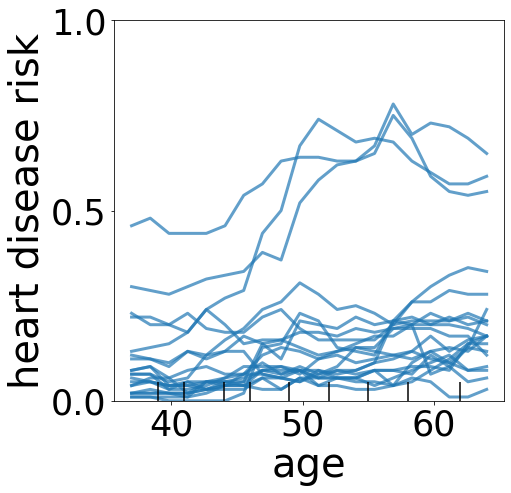

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))

display = PartialDependenceDisplay.from_estimator(
       estimator=model, X=features, features=[0], feature_names=['age'], kind="individual", subsample=20,
       n_jobs=3, ice_lines_kw = { 'alpha' : 0.7, 'linewidth' : 3.0 }, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

plt.ylabel("heart disease risk", fontsize=40)
plt.xlabel("age", fontsize=40)

plt.xticks(ticks= [40, 50, 60], fontsize=35)
plt.yticks(ticks=[0.0, 0.5, 1.0], fontsize=35)

In [11]:
ice_lines = partial_dependence(estimator=model, X=features.sample(20), features=[0], kind='individual')

In [16]:
for i, ice_line in enumerate(ice_lines['individual'][0]):
    full_data = np.array([ice_lines['values'][0], ice_line]).T
    df = pd.DataFrame(full_data, columns=['feature_values', 'predictions'])
    df.to_csv(f'ice_lines/ice_line_{i}.csv', index=False)

In [17]:
print(len(ice_lines['individual'][0]))

20
